# MiniProject 2: Optimization and Text Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd
import sklearn
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

## Part 1: Optimization

### 1.1. Run the logistic regression code using the given implementation

In [13]:
# Given implementations
logistic = lambda z: 1./ (1 + np.exp(-z))  
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

In [14]:
# Run Logistic Regression
#(Find a learning rate and a number of training iterations such that the
# model has fully converged to a solution)

diabetes_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
diabetes_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/diabetes/diabetes_test.csv', index_col=False, sep=',', engine='python')
diabetes_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/diabetes/diabetes_train.csv', index_col=False, sep=',', engine='python')
diabetes_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/diabetes/diabetes_val.csv', index_col=False, sep=',', engine='python')

x, y = diabetes_train.iloc[:,:-1].to_numpy(), diabetes_train.iloc[:,-1].to_numpy()
x_val, y_val = diabetes_val.iloc[:,:-1].to_numpy(), diabetes_val.iloc[:,-1].to_numpy()

# Plot accuracies for different leanring rates
# and different number of max iterations
def train_LR_models(x, y, rates, max_iters):
  models = list()

  for r in rates:
    _models = list()
    for iters in max_iters:
      model = LogisticRegression(True, r, 1e-4, iters)
      yh = model.fit(x,y)
      _models.append(model)
    models.append(_models)

  return models

def plot_LR_accuracies(models, x, y, title, rates, max_iters):
    accuracies = []

    for _models in models:
      _accuracies = list()
      for model in _models:
        yh = model.predict(x)
        y_pred = np.rint(yh)
        _accuracies.append(accuracy_score(y_pred, y))
      accuracies.append(_accuracies)

    i = 0
    max_acc = 0
    best_rate = 0
    for line in accuracies:
        m = max(line)
        if(m > max_acc): 
            max_acc = m
            best_rate = rates[i]
        plt.plot(line, label=str(rates[i]))
        i += 1

    max_iters_i = list(range(len(max_iters)))
    plt.title(title)
    plt.legend(loc='lower right')
    # plt.xticks(max_iters_i, max_iters)
    plt.xlabel('Max iterations')
    plt.ylabel('Accuracy score')
    plt.show()

    print('Best learning rate: ', best_rate)
    print('Maximum accuracy: ', max_acc)

First, we want to get an idea of the range we should be looking for for our learning rate. We start by looking at 0.0001, 0.001, and 0.1

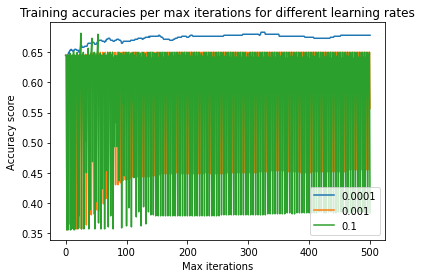

Best learning rate:  0.0001
Maximum accuracy:  0.6833333333333333


In [ ]:
rates = [0.0001, 0.001, 0.1]
max_iters = np.arange(0, 501, 1)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)

First, we want to get an idea of the range we should be looking for for our learning rate and maximum number of iterations. Below, we start by testing rates form 0.000001 to 0.0001 and maximum iterations from 0 to 10,000.
Note that the x axis in this case will be x100.

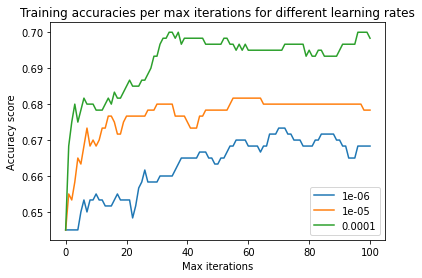

Best learning rate:  0.0001
Maximum accuracy:  0.7


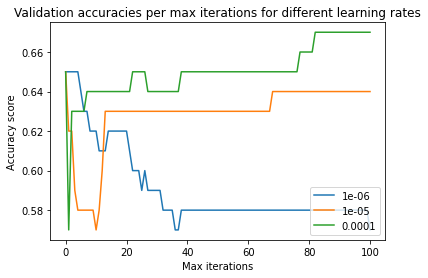

Best learning rate:  0.0001
Maximum accuracy:  0.67


In [ ]:
rates = [0.000001, 0.00001, 0.0001]
max_iters = np.arange(0, 10100, 100)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

As we can see above, all three tested learning rates seem to become steady around 3,700 max iterations. The best learning rate is 0.0001 with an accuracy of 0.7. 
In the next steps, we will continue to play around with max_iters and learning rates around 0.0001.

Below, we will try to increase the learning rate (keeping 0.0001 as a base value). In order to see the effect of changing the learning rate only, we keep the same max iterations range for now.

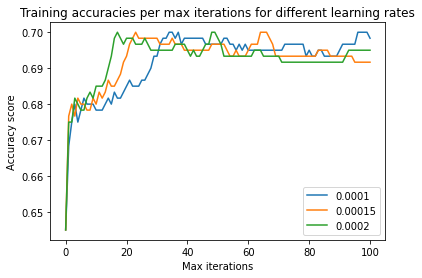

Best learning rate:  0.0001
Maximum accuracy:  0.7


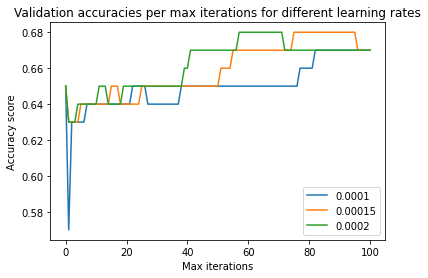

Best learning rate:  0.00015
Maximum accuracy:  0.68


In [ ]:
rates = [0.00010, 0.00015, 0.00020]
max_iters = np.arange(0, 10100, 100)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

As before, 0.0001 gives the maximal accuracy. However, the accuracy scores seem to be converging faster using 0.0002 as a learning rate. Let's investigate that new learning rate (0.0002).
Since it seems the accuracy values are somewhat steady after 3,500 max iterations, we will continue investigating with only 5,000 max iterations to reduce running time.

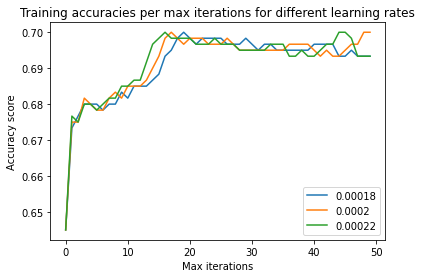

Best learning rate:  0.00018
Maximum accuracy:  0.7


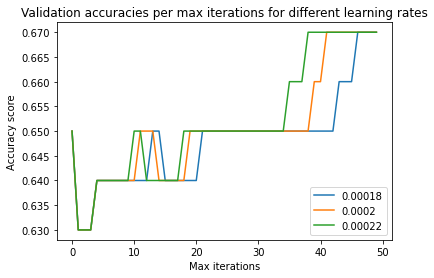

Best learning rate:  0.00018
Maximum accuracy:  0.67


In [ ]:
rates = [0.00018, 0.00020, 0.00022]
max_iters = np.arange(0, 5000, 100)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

We are getting closer to finding a good learning rate. As we can see above, the training data converges around 2,000 max iterations with all 3 learning rates. 0.00022 is the first to converge.

Let's try a much larger accuracy value to compare with 0.00022.

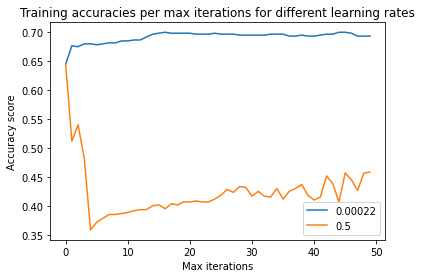

Best learning rate:  0.00022
Maximum accuracy:  0.7


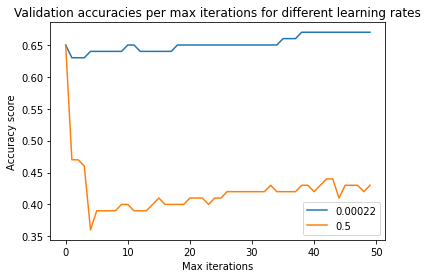

Best learning rate:  0.00022
Maximum accuracy:  0.67


In [ ]:
rates = [0.00022, 0.5]
max_iters = np.arange(0, 5000, 100)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

Now let's try with a much smaller value.

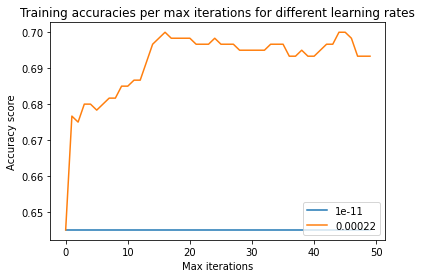

Best learning rate:  0.00022
Maximum accuracy:  0.7


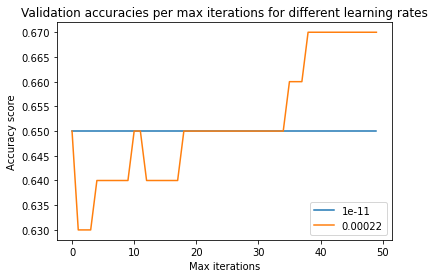

Best learning rate:  0.00022
Maximum accuracy:  0.67


In [ ]:
rates = [0.00000000001, 0.00022]
max_iters = np.arange(0, 5000, 100)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

Finally, we fine tune around 0.00022.

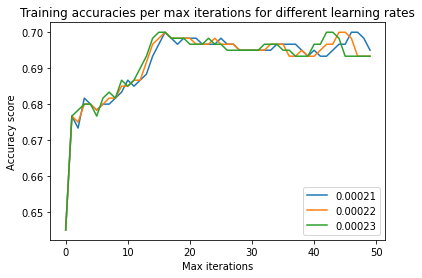

Best learning rate:  0.00021
Maximum accuracy:  0.7


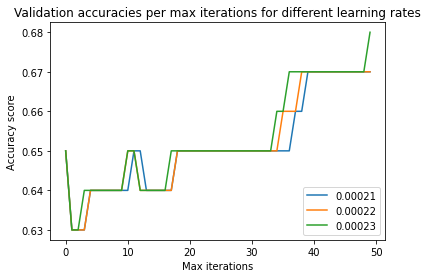

Best learning rate:  0.00023
Maximum accuracy:  0.68


In [ ]:
rates = [0.00021, 0.00022, 0.00023]
max_iters = np.arange(0, 5000, 100)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

All curves are very similar in terms of convergence. We choose a learning rate of 0.00021 since it gives us the best accuracy for the same convergence.

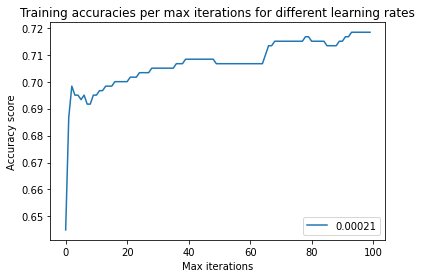

Best learning rate:  0.00021
Maximum accuracy:  0.7183333333333334


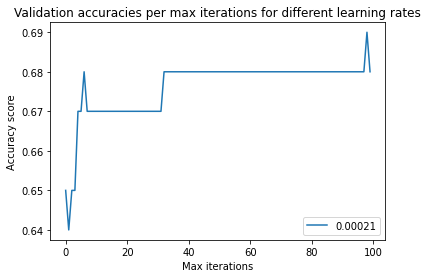

Best learning rate:  0.00021
Maximum accuracy:  0.69


In [ ]:
rates = [0.00021]
max_iters = np.arange(0, 100000, 1000)

models = train_LR_models(x, y, rates, max_iters)

plot_LR_accuracies(models, x, y, 'Training accuracies per max iterations for different learning rates', rates, max_iters)
plot_LR_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different learning rates', rates, max_iters)

We see that testing with a larger number of max iterations does not improve the accuracy much. This makes sense since we had found it started to converge to 0.7 around 3,000-4,000 max iterations.



---



### 1.2. Mini-Batch Gradient Descent

Using the ideal training rate and iterations from part 1.1, we test different batch sizes to see which one provides the ideal accuracy between the training and validation data. 

In [15]:
def fit_minibatch(self, x, y, batch_size):
  if x.ndim == 1:
    x = x[:, None]
  if self.add_bias:
    N = x.shape[0]
    x = np.column_stack([x,np.ones(N)])
  N,D = x.shape
  self.w = np.zeros(D)
  g = np.inf 
  t = 0
  # the code snippet below is for gradient descent
  while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
    for i in range(0, len(x), batch_size):
      end = min(i+batch_size, len(x))
      x_batch, y_batch = x[i:end], y[i:end]
      g = self.gradient(x_batch, y_batch)
      self.w = self.w - self.learning_rate * g 
    t += 1
  
  if self.verbose:
    print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
    print(f'the weight found: {self.w}')
  return self

LogisticRegression.fit = fit_minibatch

In [23]:
diabetes_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
diabetes_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/diabetes/diabetes_test.csv', index_col=False, sep=',', engine='python')
diabetes_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/diabetes/diabetes_train.csv', index_col=False, sep=',', engine='python')
diabetes_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/diabetes/diabetes_val.csv', index_col=False, sep=',', engine='python')

x, y = diabetes_train.iloc[:,:-1].to_numpy(), diabetes_train.iloc[:,-1].to_numpy()
x_val, y_val = diabetes_val.iloc[:,:-1].to_numpy(), diabetes_val.iloc[:,-1].to_numpy()

# Train mini-batch models with a fixed max_iter and a fixed learning rate
def train_MB_models_fixed_iters(x, y, batch_sizes):
  models = list()

  for batch_size in batch_sizes:
    model = LogisticRegression(add_bias=True, learning_rate=0.00021, max_iters=4e4, epsilon=1e-4)
    p = np.random.permutation(len(x))
    x_shuffle, y_shuffle = x[p], y[p]
    model = model.fit(x_shuffle, y_shuffle, batch_size)
    models.append(model)

  return models

# Plot function for mini-batch models with a fixed max_iter and a fixed learning rate
def plot_MB_accuracies_per_batch(models, x, y, title, batch_sizes):
    accuracies = []

    for model in models:
      yh = model.predict(x)
      y_pred = np.rint(yh)
      score = accuracy_score(y, y_pred)
      #print(f'Accuracy Score for model with batch size {model.batch_size}: {score}')
      accuracies.append(score)
    
    max_acc = max(accuracies)
    best_size = batch_sizes[np.argmax(accuracies)]
    plt.plot(batch_sizes, accuracies, label='Accuracy')

    plt.title(title)
    plt.legend(loc='lower right')
    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy score')
    plt.show()

    print('Best batch size: ', best_size)
    print('Maximum accuracy: ', max_acc)

In [18]:
# Train mini-batch models with a fixed learning rate (different batch sizes and max_iters)
def train_MB_models(x, y, batch_sizes):
  models = list()

  for batch_size in batch_sizes:
    _models = list()
    for iters in np.arange(1, 3600, 100):
      model = LogisticRegression(True, learning_rate=0.00021, max_iters=iters)
      p = np.random.permutation(len(x))
      x_shuffle, y_shuffle = x[p], y[p]
      model = model.fit(x_shuffle, y_shuffle, batch_size) # fit_minibatch
      _models.append(model)
    models.append(_models)

  return models


# Plot mini-batch models with a fixed learning rate (different batch sizes and max_iters)
def plot_MB_accuracies(models, x, y, title, batch_sizes):
    accuracies = []

    for _models in models:
      _accuracies = list()
      for model in _models:
        yh = model.predict(x)
        y_pred = np.rint(yh)
        _accuracies.append(accuracy_score(y_pred, y))
      accuracies.append(_accuracies)

    i = 0
    max_acc = 0
    best_batch = 0
    for line in accuracies:
        m = max(line)
        if(m > max_acc): 
            max_acc = m
            best_batch = batch_sizes[i]
        plt.plot(line, label=str(batch_sizes[i]))
        i += 1

    max_iters_i = list(range(len(np.arange(1, 3600, 100))))
    plt.title(title)
    plt.legend(loc='lower right')
    # plt.xticks(max_iters_i, max_iters)
    plt.xlabel('Max iterations')
    plt.ylabel('Accuracy score')
    plt.show()

    print('Best batch size: ', best_batch)
    print('Maximum accuracy: ', max_acc)

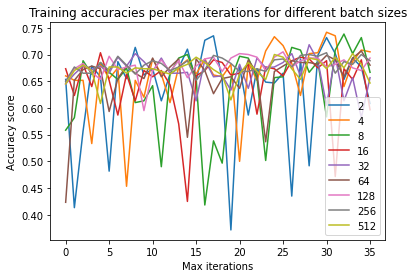

Best batch size:  4
Maximum accuracy:  0.7416666666666667


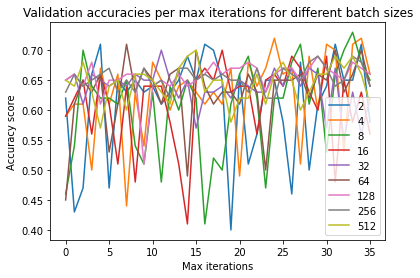

Best batch size:  8
Maximum accuracy:  0.73


In [19]:
batch_sizes = 2 ** np.arange(1, 10)

models = train_MB_models(x, y, batch_sizes)

plot_MB_accuracies(models, x, y, 'Training accuracies per max iterations for different batch sizes', batch_sizes)
plot_MB_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different batch sizes', batch_sizes)

At first sight, the plot above shows that smaller batches seem to oscillate a lot more than bigger batche sizes. Since this initial graph is very corwded, let's look at less batch sizes at a time.

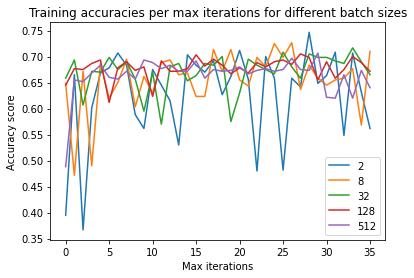

Best batch size:  2
Maximum accuracy:  0.7466666666666667


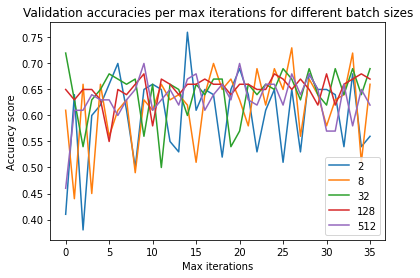

Best batch size:  2
Maximum accuracy:  0.76


In [20]:
batch_sizes = 2 ** np.arange(1, 10, 2)

models = train_MB_models(x, y, batch_sizes)

plot_MB_accuracies(models, x, y, 'Training accuracies per max iterations for different batch sizes', batch_sizes)
plot_MB_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different batch sizes', batch_sizes)

Again (but more clearly), the 512 and 128 lines seem to oscillate less than the other batches. Let's compare even less batches to get a better understanding of the graph.

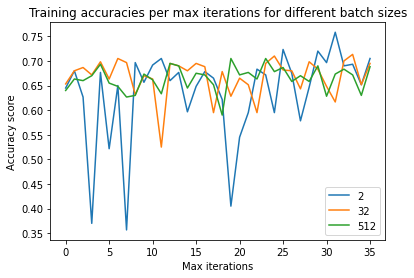

Best batch size:  2
Maximum accuracy:  0.7583333333333333


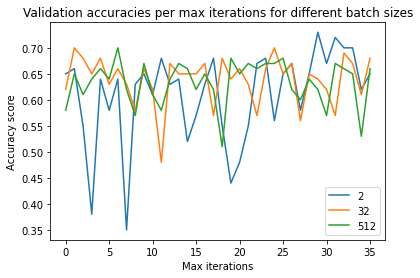

Best batch size:  2
Maximum accuracy:  0.73


In [21]:
batch_sizes = [2, 32, 512]

models = train_MB_models(x, y, batch_sizes)

plot_MB_accuracies(models, x, y, 'Training accuracies per max iterations for different batch sizes', batch_sizes)
plot_MB_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different batch sizes', batch_sizes)

Laslty, let's compare a small batch, to a medium size batch, to the full bacth - all on the same graph.

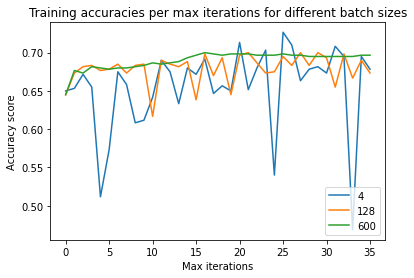

Best batch size:  4
Maximum accuracy:  0.7266666666666667


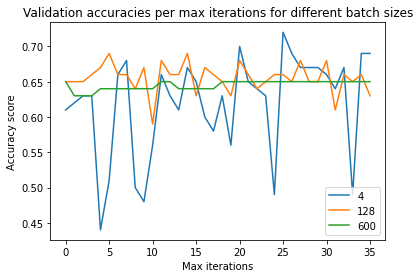

Best batch size:  4
Maximum accuracy:  0.72


In [22]:
batch_sizes = [4, 128, len(x)]

models = train_MB_models(x, y, batch_sizes)

plot_MB_accuracies(models, x, y, 'Training accuracies per max iterations for different batch sizes', batch_sizes)
plot_MB_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different batch sizes', batch_sizes)

Comparing different batch sizes to the full batch, we see that the full batch is much more steady in terms of its accuracy.

Finally, let's look at the accuracy for each batch

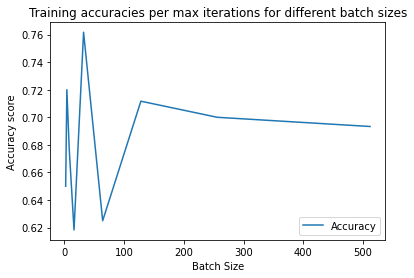

Best batch size:  32
Maximum accuracy:  0.7616666666666667


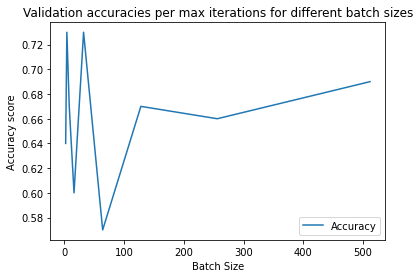

Best batch size:  4
Maximum accuracy:  0.73


In [ ]:
batch_sizes = 2 ** np.arange(1, 10)

models = train_MB_models_fixed_iters(x, y, batch_sizes)

plot_MB_accuracies_per_batch(models, x, y, 'Training accuracies per max iterations for different batch sizes', batch_sizes)
plot_MB_accuracies_per_batch(models, x_val, y_val, 'Validation accuracies per max iterations for different batch sizes', batch_sizes)

Based on the graphs, our model performs best on the training data with a batch size of 32, and best on the validation data with a batch size of 4.

However, with a batch size of 4, we could have an outlier, whereas at 32, the validation and training data both perform well.

### 1.3. Momentum with Gradient Descent

In [38]:
def fit_momentum(self, x, y, momentum):
  if x.ndim == 1:
    x = x[:, None]
  if self.add_bias:
    N = x.shape[0]
    x = np.column_stack([x,np.ones(N)])
  N,D = x.shape
  self.w = np.zeros(D)
  g = np.inf 
  t = 0
  # the code snippet below is for gradient descent
  while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
    g = self.gradient(x, y)
    w_t = momentum * self.w + (1 - momentum) * g
    self.w = self.w - self.learning_rate * w_t
    t += 1
  
  if self.verbose:
    print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
    print(f'the weight found: {self.w}')
  return self

LogisticRegression.fit = fit_momentum

In [25]:
# Plot accuracies for different momentums and a fixed number of max iterations and a fixed learning rate
def train_momentum_models_fixed_iters(x, y, momentums):
  models = list()

  for momentum in momentums:
    model = LogisticRegression(add_bias=True, learning_rate=0.00021, max_iters=4e4, epsilon=1e-4)
    p = np.random.permutation(len(x))
    x_shuffle, y_shuffle = x[p], y[p]
    model = model.fit(x_shuffle, y_shuffle, momentum)
    models.append(model)

  return models

def plot_momentum_accuracies_per_momentum(models, x, y, title, momentums):
    accuracies = []

    for model in models:
      yh = model.predict(x)
      y_pred = np.rint(yh)
      score = accuracy_score(y, y_pred)
      accuracies.append(score)
    
    max_acc = max(accuracies)
    best_momentum = momentums[np.argmax(accuracies)]
    plt.plot(momentums, accuracies, label='Accuracy')

    plt.title(title)
    plt.legend(loc='lower right')
    plt.xlabel('Momentum Value')
    plt.ylabel('Accuracy score')
    plt.show()

    print('Best Momentum: ', best_momentum)
    print('Maximum accuracy: ', max_acc)

In [39]:
# Train momentum models with a fixed learning rate (different batch sizes and max_iters)
def train_momentum_models(x, y, momentums):
  models = list()

  for momentum in momentums:
    _models = list()
    for iters in np.arange(1, 3600, 100):
      model = LogisticRegression(True, learning_rate=0.00021, max_iters=iters)
      model = model.fit(x, y, momentum) # fit_momentum
      _models.append(model)
    models.append(_models)

  return models


# Plot mini-batch models with a fixed learning rate (different batch sizes and max_iters)
def plot_momentum_accuracies(models, x, y, title, momentums):
    accuracies = []

    for _models in models:
      _accuracies = list()
      for model in _models:
        yh = model.predict(x)
        y_pred = np.rint(yh)
        _accuracies.append(accuracy_score(y_pred, y))
      accuracies.append(_accuracies)

    i = 0
    max_acc = 0
    best_momentum = 0
    for line in accuracies:
        m = max(line)
        if(m > max_acc): 
            max_acc = m
            best_momentum = momentums[i]
        plt.plot(line, label=str(momentums[i]))
        i += 1

    max_iters_i = list(range(len(np.arange(1, 3600, 100))))
    plt.title(title)
    plt.legend(loc='lower right')
    # plt.xticks(max_iters_i, max_iters)
    plt.xlabel('Max iterations')
    plt.ylabel('Accuracy score')
    plt.show()

    print('Best batch size: ', best_momentum)
    print('Maximum accuracy: ', max_acc)

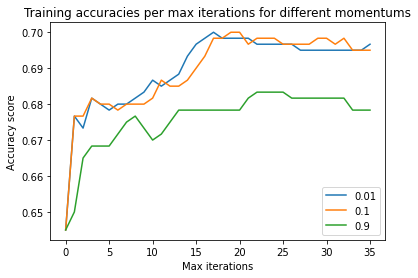

Best batch size:  0.01
Maximum accuracy:  0.7


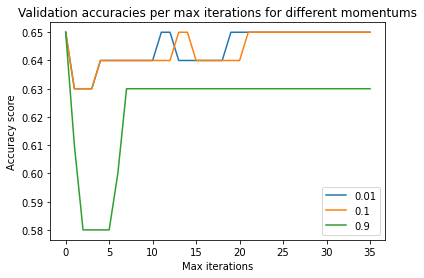

Best batch size:  0.01
Maximum accuracy:  0.65


In [40]:
momentums = [0.01, 0.1, 0.9]

models = train_momentum_models(x, y, momentums)

plot_momentum_accuracies(models, x, y, 'Training accuracies per max iterations for different momentums', momentums)
plot_momentum_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different momentums', momentums)

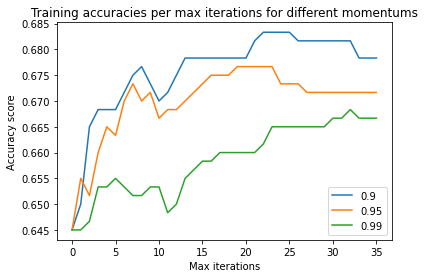

Best batch size:  0.9
Maximum accuracy:  0.6833333333333333


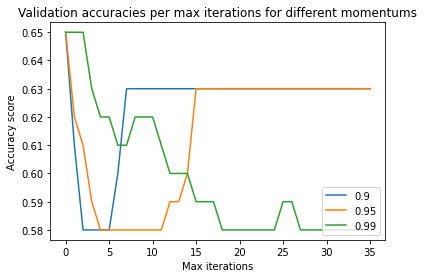

Best batch size:  0.9
Maximum accuracy:  0.65


In [41]:
momentums = [0.9, 0.95, 0.99]

models = train_momentum_models(x, y, momentums)

plot_momentum_accuracies(models, x, y, 'Training accuracies per max iterations for different momentums', momentums)
plot_momentum_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different momentums', momentums)

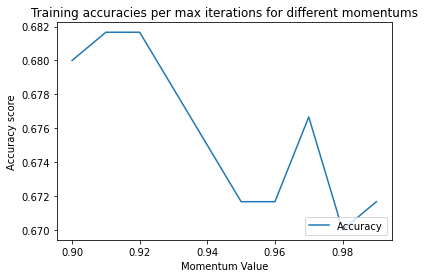

Best Momentum:  0.91
Maximum accuracy:  0.6816666666666666


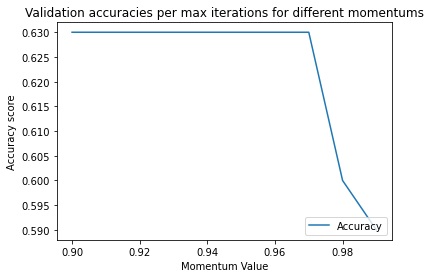

Best Momentum:  0.9
Maximum accuracy:  0.63


In [33]:
momentums = np.arange(.9, 1.0, .01)

models = train_momentum_models_fixed_iters(x, y, momentums)

plot_momentum_accuracies_per_momentum(models, x, y, 'Training accuracies per max iterations for different momentums', momentums)
plot_momentum_accuracies_per_momentum(models, x_val, y_val, 'Validation accuracies per max iterations for different momentums', momentums)

## 1.4. Momentum on smallest and largest

In [52]:
# Train minibatch-momentum models with a fixed learning rate (different batch sizes and max_iters)
def train_momentum_MB_models(x, y, momentums, batch_size):
  models = list()

  for momentum in momentums:
    _models = list()
    for iters in np.arange(1, 3600, 100):
      model = LogisticRegression(True, learning_rate=0.00021, max_iters=iters)
      p = np.random.permutation(len(x))
      end = min(batch_size, len(x))
      x_shuffle, y_shuffle = x[p], y[p]
      x_batch, y_batch = x_shuffle[0:end], y_shuffle[0:end]
      model = model.fit(x_batch, y_batch, momentum, batch_size) # fit_momentum
      _models.append(model)
    models.append(_models)

  return models

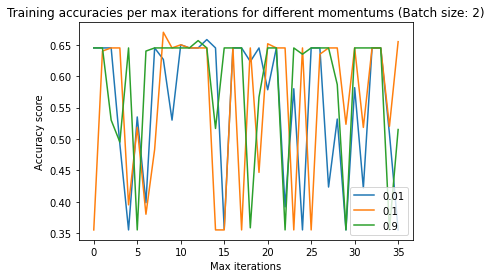

Best batch size:  0.1
Maximum accuracy:  0.67


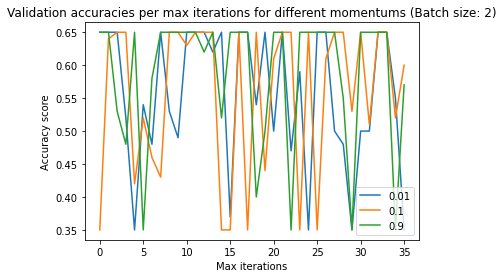

Best batch size:  0.01
Maximum accuracy:  0.65


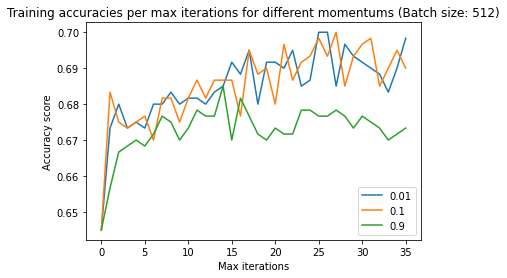

Best batch size:  0.01
Maximum accuracy:  0.7


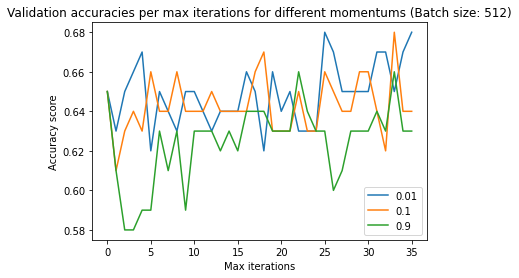

Best batch size:  0.01
Maximum accuracy:  0.68


In [53]:
momentums = [0.01, 0.1, 0.9]

models = train_momentum_MB_models(x, y, momentums, 2)

plot_momentum_accuracies(models, x, y, 'Training accuracies per max iterations for different momentums (Batch size: 2)', momentums)
plot_momentum_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different momentums (Batch size: 2)', momentums)

models = train_momentum_MB_models(x, y, momentums, 512)

plot_momentum_accuracies(models, x, y, 'Training accuracies per max iterations for different momentums (Batch size: 512)', momentums)
plot_momentum_accuracies(models, x_val, y_val, 'Validation accuracies per max iterations for different momentums (Batch size: 512)', momentums)

## Part 2: Text Classification

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
fake_news_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/fake_news/fake_news_train.csv', index_col=False, sep=',',  engine='python')
fake_news_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/fake_news/fake_news_test.csv', index_col=False, sep=',',  engine='python')
fake_news_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_A2/fake_news/fake_news_val.csv', index_col=False, sep=',',  engine='python')

In [ ]:
X_train, y_train = fake_news_train['text'].to_frame(), fake_news_train['label'].to_frame()
X_train.columns = ['text']
y_train.columns = ['label']

X_val, y_val = fake_news_val['text'].to_frame(), fake_news_val['label'].to_frame()
X_val.columns = ['text']
y_val.columns = ['label']

X_test, y_test = fake_news_test['text'].to_frame(), fake_news_test['label'].to_frame()
X_test.columns = ['text']
y_test.columns = ['label']

X_train_new, y_train_new = X_train.append(X_val), y_train.append(y_val)

**Preprocessing**

We build a pipeline that will preprocess our data such that we can extract features, so they can be used to train our ML model. 

The pipeline starts by using CountVectorization which will tokenize the elements of the text document. It will then create a matrix of token count such that we can use our bag of words implementation. 

One issue we may encounter if we were to only use CountVectorization would be that longer documents will have higher occurences of certain words. This would make it is difficult to compare long text documents to short documents because the word occurence might differ significantly. Moreover, certain words may appear more often across all documents, so we can conclude that they are less important. To get around these issues, we turn the occurences of words into their frequency in the text document and scale down less important words (features). We do this using the TfidfTransformer. 

In [ ]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english', strip_accents='ascii', analyzer='char_wb', ngram_range=(4, 7))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=150)),
])

We specify the parameters that GridSearchCV will have to try. This include the penalty, solver and C. C is the inverse of regularization strength (i.e. C=1/lambda).

In [ ]:
parameters = {
    'clf__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'clf__C': [1e-1, 1, 10, 25, 50, 100],
    }

In [ ]:
gs_clf = GridSearchCV(text_clf, param_grid = parameters, scoring='accuracy', n_jobs=-1, cv=5)

In [ ]:
gs_clf.fit(X_train_new['text'], y_train_new['label'])

In [ ]:
#Predict values based on new parameters
y_pred_acc = gs_clf.predict(X_test['text'])

Accuracy Score : 0.7703333333333333
Precision Score : 0.7753438614365766
Recall Score : 0.8598870056497175
F1 Score : 0.8154299491025984



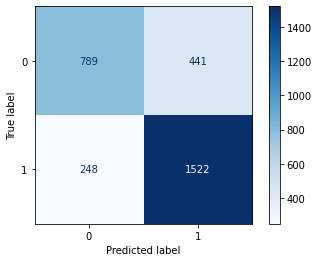


clf__C: 10
clf__penalty: 'l2'
clf__solver: 'sag'


In [ ]:
# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test['label'],y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)) + '\n')

# Logistic Regression (Grid Search) Confusion matrix
cm = confusion_matrix(y_test,y_pred_acc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_clf.classes_)
disp.plot(values_format = '.5g', cmap='Blues')
plt.show()
print('')

# Print best param
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))